In [51]:
import multiprocessing
from tqdm.notebook import tqdm
import numpy as np
import scipy.stats as st
import numba

# Plotting modules
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

# Line profiler (can install with conda install line_profiler)
%load_ext line_profiler

Loading BokehJS ...

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Goal, a vertical model of biofilm growth. 

In [52]:
# Column 0 is change in m, column 1 is change in p
simple_update = np.array([[1, 0],   # Make mRNA transcript
                          [-1, 0],  # Degrade mRNA
                          [0, 1],   # Make protein
                          [0, -1]], # Degrade protein
                        )
def simple_propensity(propensities, population, t, beta_m, beta_p, gamma):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m, p = population
    
    # Update propensities
    propensities[0] = beta_m      # Make mRNA transcript
    propensities[1] = m           # Degrade mRNA
    propensities[2] = beta_p * m  # Make protein
    propensities[3] = gamma * p   # Degrade protein
    
def sample_discrete_scipy(probs):
    """Randomly sample an index with probability given by probs."""
    return st.rv_discrete(values=(range(len(probs)), probs)).rvs()

def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

# Make dummy probs
probs = np.array([0.1, 0.3, 0.4, 0.05, 0.15])

print('Result from scipy.stats:')
%timeit sample_discrete_scipy(probs)

print('\nResult from hand-coded method:')
%timeit sample_discrete(probs)

Result from scipy.stats:
363 µs ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Result from hand-coded method:
1.18 µs ± 20.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [53]:
def gillespie_draw(propensity_func, propensities, population, t, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, t, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    t : float
        Value of the current time.
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

In [54]:
def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

In [55]:
# Specify parameters for calculation
args = (10.0, 10.0, 0.4)
time_points = np.linspace(0, 50, 101)
population_0 = np.array([0, 0], dtype=int)
size = 100

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
samples = np.empty((size, len(time_points), 2), dtype=int)

# Run the calculations
for i in tqdm(range(size)):
    samples[i,:,:] = gillespie_ssa(simple_propensity, simple_update,
                                population_0, time_points, args=args)

  0%|          | 0/100 [00:00<?, ?it/s]

In [56]:
# Set up plots
plots = [bokeh.plotting.figure(plot_width=300,
                               plot_height=200,
                               x_axis_label='dimensionless time',
                               y_axis_label='number of mRNAs'),
         bokeh.plotting.figure(plot_width=300,
                               plot_height=200,
                               x_axis_label='dimensionless time',
                               y_axis_label='number of proteins')]

# Plot trajectories and mean
for i in [0, 1]:
    for x in samples[:,:,i]:
        plots[i].line(time_points, x, line_width=0.3, 
                      alpha=0.2, line_join='bevel')
    plots[i].line(time_points, samples[:,:,i].mean(axis=0),
                  line_width=6, color='orange', line_join='bevel')

# Link axes
plots[0].x_range = plots[1].x_range

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=2))

In [57]:
@numba.njit
def simple_propensity(propensities, population, t, beta_m, beta_p, gamma):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m, p = population
    
    # Update propensities
    propensities[0] = beta_m      # Make mRNA transcript
    propensities[1] = m           # Degrade mRNA
    propensities[2] = beta_p * m  # Make protein
    propensities[3] = gamma * p   # Degrade protein

In [59]:
samples = biocircuits.gillespie_ssa(simple_propensity, 
                                    simple_update, 
                                    population_0, 
                                    time_points, 
                                    size=1000, 
                                    args=args,
                                    n_threads=4)

# My Code

In [3]:
import multiprocessing
from tqdm.notebook import tqdm
import numpy as np
import scipy.stats as st
import numba

# Plotting modules
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

# Line profiler (can install with conda install line_profiler)
%load_ext line_profiler

Loading BokehJS ...

$$\require{mhchem}$$
$$\ce{\emptyset ->[\beta_m] m ->[\gamma_m] \emptyset}$$
$$\ce{m ->[\beta_p] p ->[\gamma_p] \emptyset}$$
Converting this into the Glillespie Algorithim format:
$$ reaction, r_i \qquad propensity, a_i$$
$$\ce{m -> m + 1}, \qquad \beta_m$$
$$\ce{m -> m - 1}, \qquad \gamma_m m$$
$$\ce{p -> p + 1}, \qquad \beta_p m$$
$$\ce{p -> p - 1}, \qquad \gamma_p p$$

In [2]:
# We first make an update function, this represents the network and updates
# each variable by its ratio. Note that this doesn't take into account rates.
# That will be taken into accound byt the propensity function.

#                       [m,  P]
basicReaction_update = np.array([[ 1, 0], # Make mRNA transcript
                        [-1, 0], # Degrrade mRNA transcript
                        [0,  1], # Make 
                        [0, -1]],
                        dtype = int)

# This array can then be passed at each iteration to update each variable.

# Now we need to construct a propensity function that takes in the current 
# propensities and updates them according to the current variables and time
# (order is very specific).
def basicPropensity(propensities, variables, t, beta_m, gamma_m, beta_p, gamma_p):
    # Extract variables
    m, p = variables
    
    # Update propensities
    propensities[0] = beta_m # Make mRNA transcript
    propensities[1] = gamma_m * m # Degrade mRNA
    propensities[2] = beta_p * m # Make protein from mRNA
    propensities[3] = gamma_p *p # Degrade protein

# Now we need to make a function that will sample the reactions based on their
# propensity rate. To do this we generate a random number, and between 0 and 1,
# then sum our propensities untill they are greater than the random number.
# The last propensity summed will be chosen. It is important for this that
# we divide the propensities by their total so that they have a sum total 
# of 1 (as they represent propability of reaction "firing").

def sample_discrete(probabilities):
    # Generate random number
    r_num = np.random.rand()
    
    # Find assosiated propensity
    ind = 0
    prob_sum = 0.0
    while prob_sum < r_num:
        prob_sum += probabilities[ind]
        ind += 1
    return ind - 1

# Now we can construct a gillespie_draw function, this will combine all the 
# funciton constructed so far such that gillespie_draw will: 1) Calculate the
# new propensites, 2) Sum propensites, 3) Calculate dt, 4) Compute probabilites
# from propensities, 5) Draw a random reaction, 6) return that reaction and dt.

def gillespie_draw(propensity_func, propensities, variables, t, args=()):
    # 1) Calculate new propensites
    propensity_func(propensities, variables, t, *args)
    
    # 2) Sum propensities
    propensity_sum = propensities.sum()
    
    # 3) Compute next time
    dt = np.random.exponential(1.0 / propensity_sum)
    
    # 4) Compute reaction probabilites from propensities
    reaction_probabilites = propensities / propensity_sum
    
    # 5) Draw a random reaction
    chosen_reaction = sample_discrete(reaction_probabilites)
    
    return chosen_reaction, dt

# Now we will construct a functions to run the gilespie algorithim
def gillespie_algorithim(propensity_function, update_array, initial_conditions, time_points, args=()):
    # Initialise output
    pop_out = np.empty((len(time_points), update_array.shape[1]), dtype = int)

    # Initialise and perform simulation
    index = 0
    time_index = 1
    time = time_points[0]
    variables = initial_conditions.copy()
    pop_out[0,:] = variables
    propensities = np.zeros(update_array.shape[0])
    while index < len(time_points):
        while time < time_points[time_index]:
            # Draw reaction and time step
            reaction, dt = gillespie_draw(propensity_function, propensities, variables, time, args)

            # Update variables
            variables_previous = variables.copy()
            variables += update_array[reaction, :]

            # Increment time
            time += dt

        # Update index
        index = np.searchsorted(time_points > time, True)

        # Update the variables
        pop_out[time_index:min(index, len(time_points))] = variables_previous

        # Increment index
        time_index = index

    return pop_out

In [3]:
# Now we can run the simulation
# beta_m = 10, gamma_m = 1, beta_p = 10, gamma_p = 0.4
args = (10.0, 1.0, 10.0, 0.4)
time_points = np.linspace(0, 50, 101)
initial_conditions = np.array([0, 0],  dtype = int)
iterations = 100

# See random number for reproducibility
np.random.seed(420)

# Initialise output array
out_variables = np.empty((iterations, len(time_points), 2), dtype = int)

# Run the calculations
for index in tqdm(range(iterations)):
    out_variables[index, :, :] = gillespie_algorithim(basicPropensity, basicReaction_update, initial_conditions, time_points, args = args)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Now we can plot the results
plots = [bokeh.plotting.figure(plot_width = 300, plot_height = 200, x_axis_label = 'time', y_axis_label = 'number of mRNAs'),
         bokeh.plotting.figure(plot_width = 300, plot_height = 200, x_axis_label = 'time', y_axis_label = 'number of protein')]
         
for index in [0, 1]:
    for out_variables_current in out_variables[:,:,index]:
        plots[index].line(time_points, out_variables_current, line_width = 0.3, alpha = 0.2, line_join = 'bevel')
    plots[index].line(time_points, out_variables[:,:,index].mean(axis = 0), line_width = 6, color = 'orange', line_join = 'bevel')
#Link axes
plots[0].x_range = plots[1].x_range

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols = 2))

In [61]:
# Now trying the sped up version using the biocircuits algorithim
import biocircuits
basicReaction_update = np.array([[ 1, 0], # Make mRNA transcript
                        [-1, 0], # Degrrade mRNA transcript
                        [0,  1], # Make Protein
                        [0, -1]],# Degrade protein
                        dtype = int)
@numba.njit
def basicPropensity(propensities, variables, t, beta_m, gamma_m, beta_p, gamma_p):
    # Extract variables
    m, p = variables
    
    # Update propensities
    propensities[0] = beta_m # Make mRNA transcript
    propensities[1] = gamma_m * m # Degrade mRNA
    propensities[2] = beta_p * m # Make protein from mRNA
    propensities[3] = gamma_p *p # Degrade protein
    
    
initial_conditions = np.array([0, 0],  dtype = int)
time_points = np.linspace(0, 50, 101)
iterations = 1000
# beta_m = 10, gamma_m = 1, beta_p = 10, gamma_p = 0.4
args = (10.0, 1.0, 10.0, 0.4)

out_variables = biocircuits.gillespie_ssa(basicPropensity, basicReaction_update, initial_conditions, time_points,
                                         size = iterations, args = args, n_threads = 4)

In [64]:
plots = [bokeh.plotting.figure(plot_width = 300, plot_height = 200, x_axis_label = 'time', y_axis_label = 'mRNA'),
        bokeh.plotting.figure(plot_width = 300, plot_height = 200, x_axis_label = 'time', y_axis_label = 'proteins')]

for index in [0, 1]:
    for current_out_variables in out_variables[::100, :, index]:
        plots[index].line(time_points, current_out_variables, line_width = 0.3, alpha = 0.2, line_join = 'bevel')
    plots[index].line(time_points, out_variables[:,:,index].mean(axis=0), line_width = 6, color = 'orange', line_join = 'bevel')
    
plots[0].x_range = plots[1].x_range

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols = 2))

# Trialling with SigB regulation

$$\require{mhchem}$$ 
Transcription:
$$\ce{G_{X} ->[\xi s_{X}] G_{X} + R_{X}}$$
Translation
$$\ce{R_{X} ->[\beta] R_{X} + X}$$
Degrdataion:
$$\ce{R_{X} ->[\delta] \emptyset} \qquad \ce{X ->[\epsilon] \emptyset}$$
Temporarily binding:
$$\ce{B + G_{A} <=>[b_{B}][u_{B}] BG_{A}}$$

Parameter list:
 - Translation rate: $\beta = 0.05s^{-1}$
 - Transcription rate: $s_A = 0.7s^{-1},\ s_B = 0.25\ or\ 0.5 s^{-1}$
 - Stress: $\xi = 10^g, g \in \mathbb{U}[ log_{10}(5\times 10^{-5}),\ log_{10}(5\times 10^{-3}) ]$
 - Degradtion rate: $\delta = 0.005s^{-1}R_{X}^{-1}, \ \epsilon = 5\times10^{-3}s^{-1}X^{-1}$
 - Binding and unbinding rate: $b_{B} = 1.0s^{-1}X^{-1}, \ u_{B} = 0.1s^{-1}$

In [4]:
def sample_discrete(probabilities):
    # Generate random number
    r_num = np.random.rand()
    
    # Find assosiated propensity
    ind = 0
    prob_sum = 0.0
    while prob_sum < r_num:
        prob_sum += probabilities[ind]
        ind += 1
    return ind - 1

def gillespie_draw(propensity_func, propensities, variables, t, args=()):
    # 1) Calculate new propensites
    propensity_func(propensities, variables, t, *args)
    
    # 2) Sum propensities
    propensity_sum = propensities.sum()
    
    # 3) Compute next time
    dt = np.random.exponential(1.0 / propensity_sum)
    
    # 4) Compute reaction probabilites from propensities
    reaction_probabilites = propensities / propensity_sum
    
    # 5) Draw a random reaction
    chosen_reaction = sample_discrete(reaction_probabilites)
    
    return chosen_reaction, dt

# Now we will construct a functions to run the gilespie algorithim
def gillespie_algorithim(propensity_function, update_array, initial_conditions, time_points, args=()):
    # Initialise output
    pop_out = np.empty((len(time_points), update_array.shape[1]), dtype = int)

    # Initialise and perform simulation
    index = 0
    time_index = 1
    time = time_points[0]
    variables = initial_conditions.copy()
    pop_out[0,:] = variables
    propensities = np.zeros(update_array.shape[0])
    while index < len(time_points):
        while time < time_points[time_index]:
            # Draw reaction and time step
            reaction, dt = gillespie_draw(propensity_function, propensities, variables, time, args)

            # Update variables
            variables_previous = variables.copy()
            variables += update_array[reaction, :]

            # Increment time
            time += dt

        # Update index
        index = np.searchsorted(time_points > time, True)

        # Update the variables
        pop_out[time_index:min(index, len(time_points))] = variables_previous

        # Increment index
        time_index = index

    return pop_out

In [5]:



# So we have six species: G_A, R_A, A, G_B, R_B, B, BG_A
# Converting to gillespie formulas and propensities
# Reaction       , propensity
# Transcription
# R_A -> R_A + 1   , xi*s_A * G_A
# R_B -> R_B + 1   , xi*s_B * G_B
# RNA degradation
# R_A -> R_A - 1   , R_A * delta
# R_B -> R_B - 1   , R_B * delta
# Translation
# A -> A + 1       , R_A * beta
# B -> B + 1       , R_B * beta
# Protein Degradation
# A -> A - 1       , A * epsilon
# B -> B - 1       , B * epsilon
# Protien and Gene Binding (Simultanious)
# BG_A -> BG_A + 1 , B * G_A * b_B
# B -> B - 1       , B * G_A * b_B
# G_A -> G_A -1    , B * G_A * b_B
# Protien and Gene Unbinding (Simultanious)
# BG_A -> BG_A - 1 , BG_A * u_B
# B -> B + 1       , BG_A * u_B
# G_A -> G_A + 1   , BG_A * u_B

#                          G_A,  R_A,    A,  G_B,  R_B,    B, BG_A
SigB_update = np.array([[    0,    1,    0,    0,    0,    0,    0],  # Transcription R_A
                        [    0,    0,    0,    0,    1,    0,    0],  # Transcription R_B
                        [    0,   -1,    0,    0,    0,    0,    0],  # Degrade R_A
                        [    0,    0,    0,    0,   -1,    0,    0],  # Degrade R_A
                        [    0,    0,    1,    0,    0,    0,    0],  # Translation A
                        [    0,    0,    0,    0,    0,    1,    0],  # Translation B
                        [    0,    0,   -1,    0,    0,    0,    0],  # Degrade A
                        [    0,    0,    0,    0,    0,   -1,    0],  # Degrade B
                        [   -1,    0,    0,    0,    0,   -1,    1],  # Protien and Gene Binding (Simultanious)
                        [    1,    0,    0,    0,    0,    1,   -1]], # Protien and Gene Unbinding (Simultanious)
                      dtype = int)

def SigB_propensity(propensities, species, t, beta, s_A, s_B, xi, delta, epsilon, b_B, u_B):
    G_A, R_A, A, G_B, R_B, B, BG_A = species
    
    propensities[0] = xi * s_A * G_A # Transcription R_A
    propensities[1] = xi * s_B * G_B # Transcription R_B
    propensities[2] = R_A * delta    # Degrade R_A
    propensities[3] = R_B * delta    # Degrade R_B
    propensities[4] = R_A * beta     # Translation A
    propensities[5] = R_B * beta     # Translation B
    propensities[6] = A * epsilon    # Degrade A
    propensities[7] = B * epsilon    # Degrade B
    propensities[8] = B * G_A * b_B  # Protien and Gene Binding (Simultanious)
    propensities[9] = BG_A * u_B     # Protien and Gene Unbinding (Simultanious)


In [6]:
    
#       beta, s_A,  s_B,             xi, delta, epsilon, b_B, u_B
args = (0.05, 0.7, 0.25, np.power(10, np.log10(5e-3)), 0.005,    5e-3,   1, 0.1)
#                               G_A,   R_A,    A,  G_B,  R_B,    B, BG_A
initial_conditions = np.array([    1,    0,    0,    1,    0,    0,    0],  dtype = int)

time_points = np.linspace(0, int(1*6.5*60*100), int(1*6.5*60))

iterations = 10

# See random number for reproducibility
np.random.seed(420)

# Initialise output array
out_variables = np.empty((iterations, len(time_points), len(initial_conditions)), dtype = int)

In [7]:
for index in tqdm(range(iterations)):
    out_variables[index, :, :] = gillespie_algorithim(SigB_propensity, SigB_update, initial_conditions, time_points, args = args)

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
# G_A, R_A, A, G_B, R_B, B, BG_A
plots = [bokeh.plotting.figure(plot_width = 300, plot_height = 200, x_axis_label = 'time', y_axis_label = 'Gene A'),
         bokeh.plotting.figure(plot_width = 300, plot_height = 200, x_axis_label = 'time', y_axis_label = 'mRNA A'),
         bokeh.plotting.figure(plot_width = 300, plot_height = 200, x_axis_label = 'time', y_axis_label = 'Protein A'),
         bokeh.plotting.figure(plot_width = 300, plot_height = 200, x_axis_label = 'time', y_axis_label = 'Gene B'),
         bokeh.plotting.figure(plot_width = 300, plot_height = 200, x_axis_label = 'time', y_axis_label = 'mRNA B'),
         bokeh.plotting.figure(plot_width = 300, plot_height = 200, x_axis_label = 'time', y_axis_label = 'Protein B'),
         bokeh.plotting.figure(plot_width = 300, plot_height = 200, x_axis_label = 'time', y_axis_label = 'Gene A:Protein B'),
        ]

for index in range(0,7):
    for current_out_variables in out_variables[::100, :, index]:
        plots[index].line(time_points, current_out_variables, line_width = 0.3, alpha = 1, line_join = 'bevel')
    plots[index].line(time_points, out_variables[:,:,index].mean(axis=0), line_width = 6, color = 'orange', line_join = 'bevel')
    
plots[0].x_range = plots[1].x_range

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols = 3))

# Simple Rectangle Display and Movie

In [15]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatch
from matplotlib.patches import FancyBboxPatch
import time
from matplotlib.animation import *

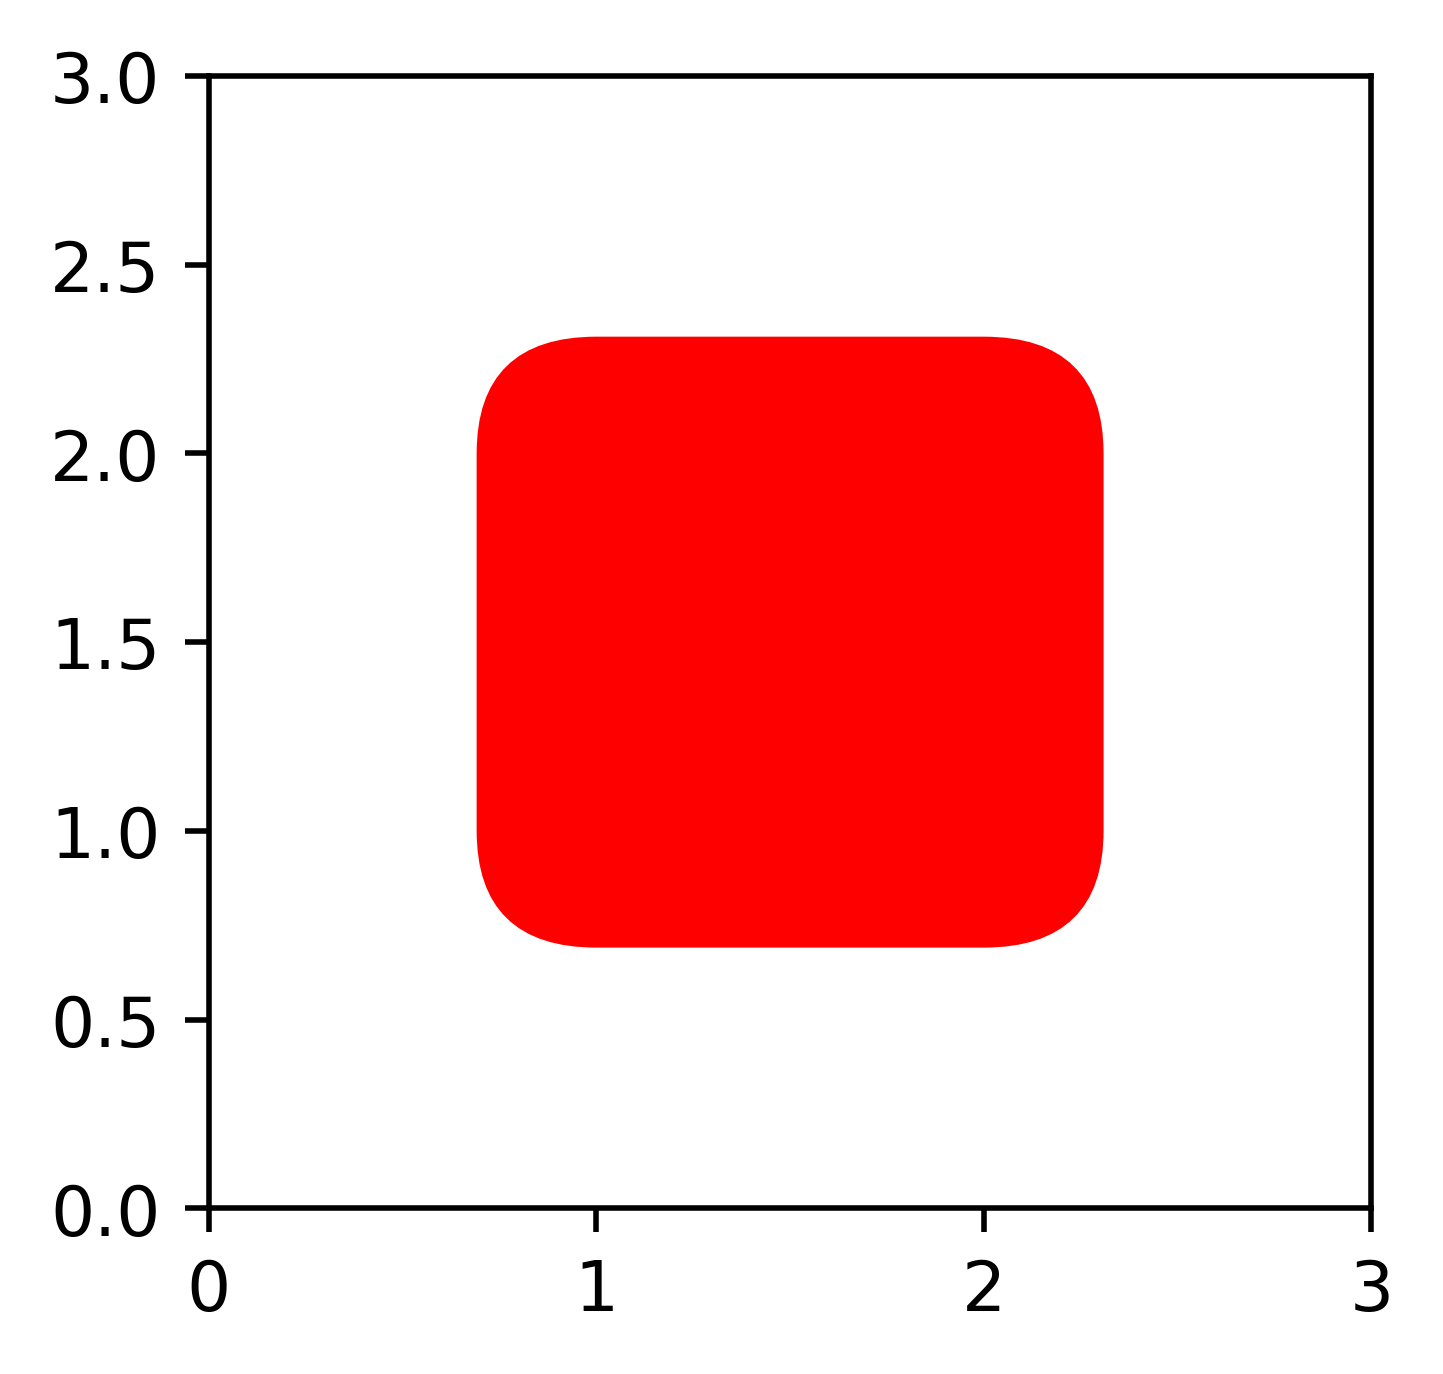

In [116]:
fig = plt.figure(figsize = (3, 3))
ax = plt.gca()
fig.set_dpi(500)
cell = FancyBboxPatch((1,1), 1, 1, boxstyle='round', color = [0,1,0], animated = True)
ax.set_xlim(0,3)
ax.set_ylim(0,3)

def animation_init():
    cell.color = [0,0,0]
    ax.add_patch(cell)
    return cell
def animation_update(frame_number):
    cell.set_color([frame_number/255, 0,0])
    return cell

animation = FuncAnimation(fig, animation_update, frames = range(1,255), init_func = animation_init, interval = 100)

animation.save('animation1.mp4', fps=30, 
          extra_args=['-vcodec', 'h264', 
                      '-pix_fmt', 'yuv420p'])

# SigB Stress Gradient Display and Movie

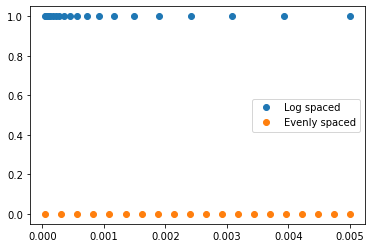

In [67]:
# To generate stress gradient we can either use an evenly spaced xi value, or a log spaced xi value. Need to clarify which paper is refering to. For now I will use evenly spaced.
x_log = np.logspace(np.log10(5e-5), np.log10(5e-3), 20, endpoint = True)
y_log = np.ones(20)
x_even = np.power(10, np.log10(np.linspace(5e-5, 5e-3, 20, endpoint = True)))
y_even = np.zeros(20)
plt.plot(x_log,y_log,'o', label = 'Log spaced')
plt.plot(x_even, y_even,'o', label = 'Evenly spaced')
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

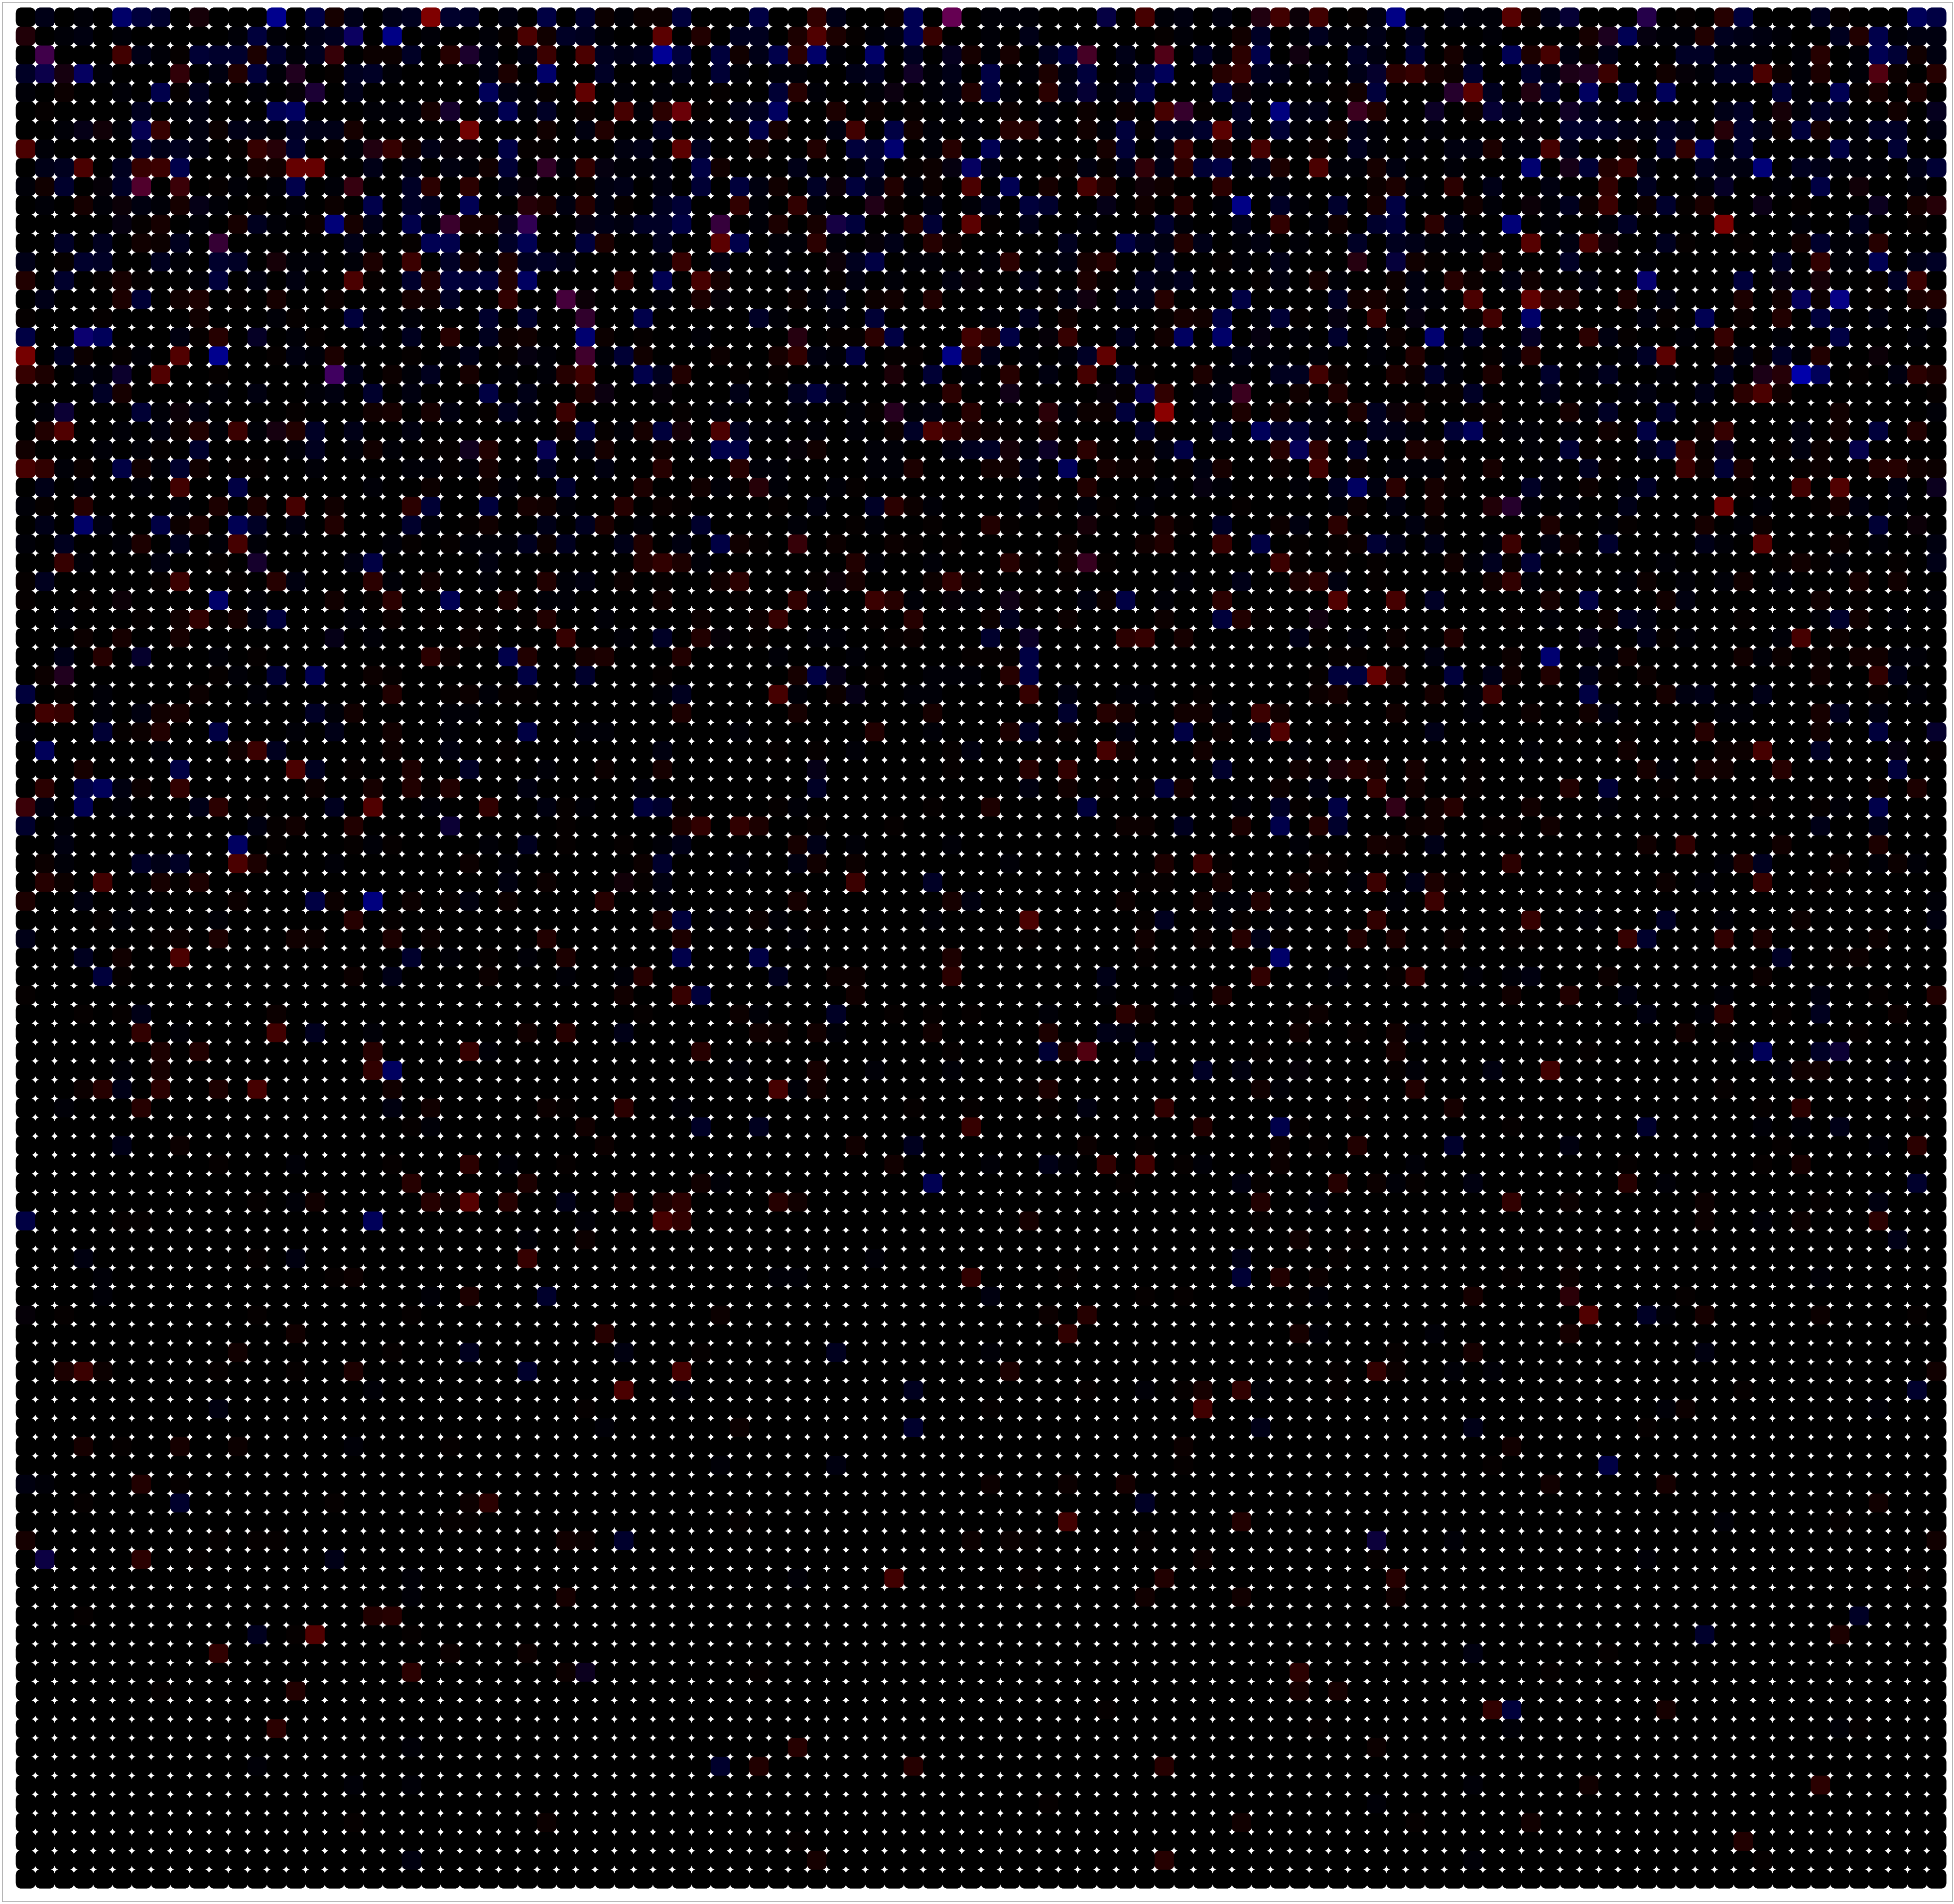

In [186]:
cells_z_number = 100
cells_x_number = 100

# +1 accounts extra padding in limits, specifically the -1
fig = plt.figure(figsize = (cells_x_number + 1, cells_z_number + 1))
ax = plt.gca()
fig.set_dpi(50)
cell_array = np.empty((cells_x_number, cells_z_number), dtype = 'object')

time_max = 4000*10
time_points = np.linspace(0, time_max, time_max)
stress_gradient = np.logspace(np.log10(5e-5), np.log10(5e-3), cells_z_number, endpoint = True)
out_variables = np.empty((cells_z_number, cells_x_number, len(time_points), len(initial_conditions)), dtype = int)

for cell_z_index in range(0, cells_z_number):
    for index in tqdm(range(cells_x_number)):
        args = (0.05, 0.7, 0.25, stress_gradient[cell_z_index], 0.005,    5e-3,   1, 0.1)
        out_variables[cell_z_index, index, :, :] = gillespie_algorithim(SigB_propensity, SigB_update, initial_conditions, time_points, args = args)  

avg_in_z_A = np.max(out_variables[:, :, :, 2], axis=(1,2)) + 1e-4       
avg_in_z_B = np.max(out_variables[:, :, :, 5], axis=(1,2)) + 1e-4 
avg_in_z_A[:] = max(avg_in_z_A)*0.8
avg_in_z_B[:] = max(avg_in_z_B)*0.8

for cell_z in range(0, cells_z_number):
    for cell_x in range(0, cells_x_number):
        cell_array[cell_x][cell_z] = FancyBboxPatch((cell_x, cell_z), 0.4, 0.4, boxstyle='round', facecolor = [1, 1, 1], edgecolor = [0,0,0], animated = True)
        ax.add_patch(cell_array[cell_x][cell_z])

def SigB_animation_init():
    for cell_z in range(0, cells_z_number):
        for cell_x in range(0, cells_x_number):
            cell_array[cell_x][cell_z].set_color([0,0,0])
            ax.add_patch(cell_array[cell_x][cell_z])
    ax.set_xlim(-1, cells_x_number)
    ax.set_ylim(-1, cells_z_number)
    plt.tick_params('both', bottom = False, left = False, labelbottom = False, labelleft = False)
    return cell_array

time_step_skip = 10

def SigB_animation_update(frame_number):
    for cell_z in range(0, cells_z_number):
        for cell_x in range(0, cells_x_number):
            cell_array[cell_x][cell_z].set_color([np.clip(out_variables[cell_z, cell_x, frame_number*time_step_skip, 2]/avg_in_z_A[cell_z], 0, 1), 0, np.clip(out_variables[cell_z, cell_x, frame_number*time_step_skip, 5]/avg_in_z_B[cell_z], 0, 1)])
    return cell_array

animation = FuncAnimation(fig, SigB_animation_update, frames = range(0, int(time_max/time_step_skip)), init_func = SigB_animation_init, interval = 1)

animation.save('animation11NormalisedByMaxMax80perFaster.mp4', fps=120, 
          extra_args=['-vcodec', 'h264', 
                      '-pix_fmt', 'yuv420p'])

plt.show()

In [182]:
print(np.mean(out_variables[:, :, :, 2], axis=(1,2)), np.max(out_variables[:, :, :, 5], axis=(1,2)))
print(avg_in_z_A)

[0.099705  0.1092325 0.061905  0.0926325 0.155105  0.2496425 0.30371
 0.31952   0.385645  0.4185325 0.6136    0.7537125 0.8485975 0.87426
 0.9441925 1.23019   1.367205  1.2793425 1.20948   1.364575 ] [ 9  7  9 11 15 17 16 13 14 16 18 13 23 16 20 26 23 23 25 38]
[1.367305 1.367305 1.367305 1.367305 1.367305 1.367305 1.367305 1.367305
 1.367305 1.367305 1.367305 1.367305 1.367305 1.367305 1.367305 1.367305
 1.367305 1.367305 1.367305 1.367305]


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

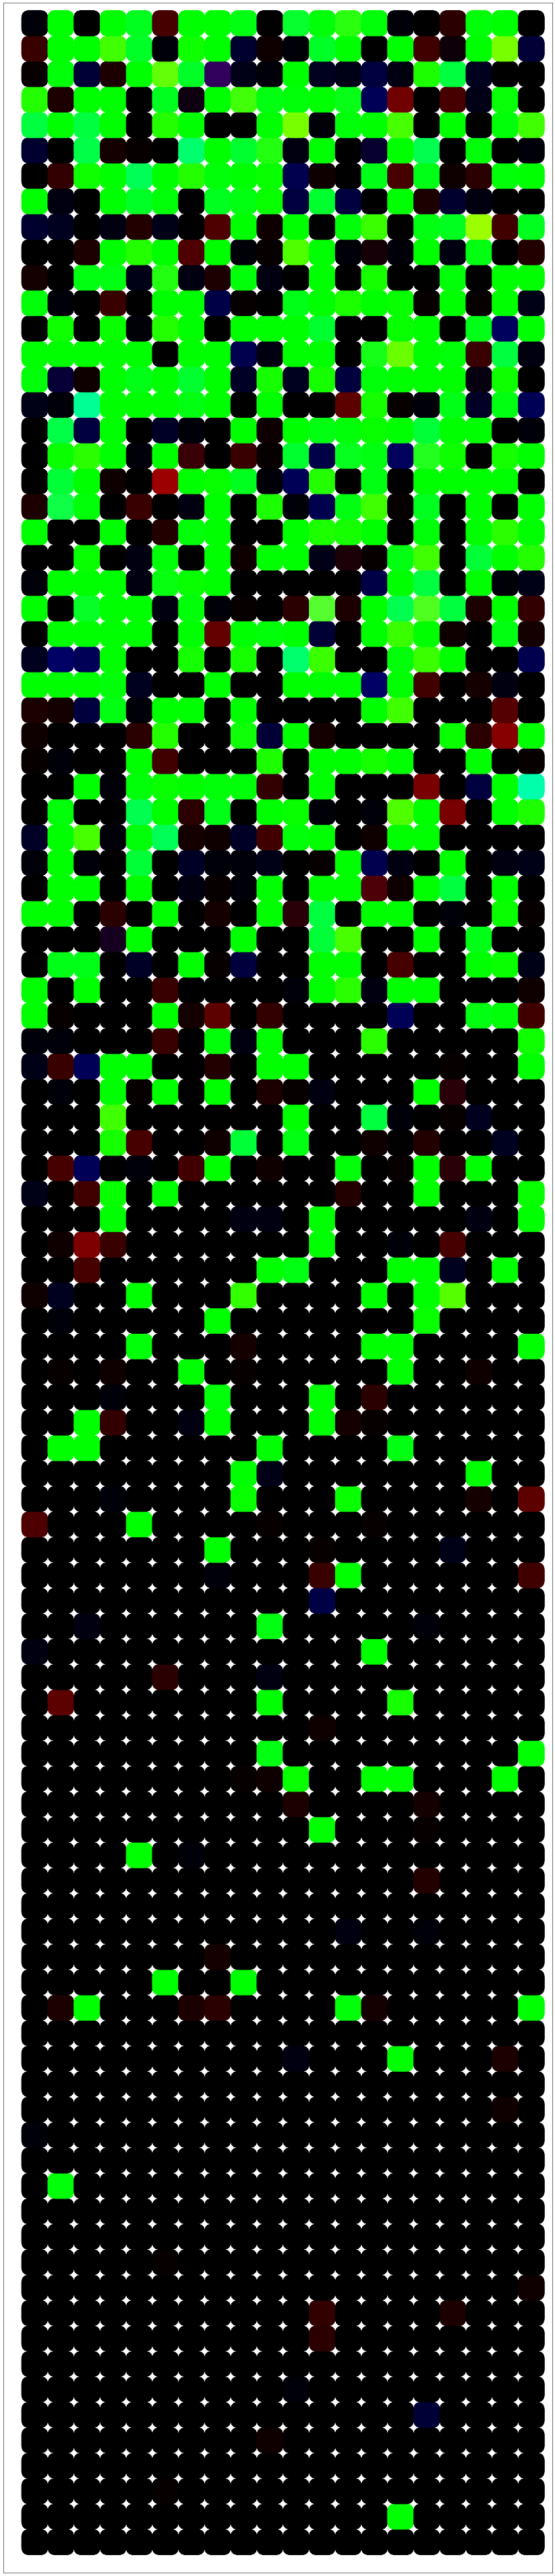

In [83]:

cells_z_number = 100
cells_x_number = 20

# +1 accounts extra padding in limits, specifically the -1
fig = plt.figure(figsize = (cells_x_number + 1, cells_z_number + 1))
ax = plt.gca()
fig.set_dpi(50)
cell_array = np.empty((cells_x_number, cells_z_number), dtype = 'object')

time_max = 4000*10
time_points = np.linspace(0, time_max, time_max)
stress_gradient = np.logspace(np.log10(5e-5), np.log10(5e-3), cells_z_number, endpoint = True)
out_variables = np.empty((cells_z_number, cells_x_number, len(time_points), len(initial_conditions)), dtype = int)

for cell_z_index in range(0, cells_z_number):
    for index in tqdm(range(cells_x_number)):
        args = (0.05, 0.7, 0.25, stress_gradient[cell_z_index], 0.005,    5e-3,   1, 0.1)
        out_variables[cell_z_index, index, :, :] = gillespie_algorithim(SigB_propensity, SigB_update, initial_conditions, time_points, args = args)  

avg_in_z_A = np.max(out_variables[:, :, :, 2], axis=(1,2)) + 1e-4       
avg_in_z_B = np.max(out_variables[:, :, :, 5], axis=(1,2)) + 1e-4 
avg_in_z_A[:] = max(avg_in_z_A)*0.8
avg_in_z_B[:] = max(avg_in_z_B)*0.8

for cell_z in range(0, cells_z_number):
    for cell_x in range(0, cells_x_number):
        cell_array[cell_x][cell_z] = FancyBboxPatch((cell_x, cell_z), 0.4, 0.4, boxstyle='round', facecolor = [1, 1, 1], edgecolor = [0,0,0], animated = True)
        ax.add_patch(cell_array[cell_x][cell_z])

def SigB_animation_init():
    for cell_z in range(0, cells_z_number):
        for cell_x in range(0, cells_x_number):
            cell_array[cell_x][cell_z].set_color([0,0,0])
            ax.add_patch(cell_array[cell_x][cell_z])
    ax.set_xlim(-1, cells_x_number)
    ax.set_ylim(-1, cells_z_number)
    plt.tick_params('both', bottom = False, left = False, labelbottom = False, labelleft = False)
    return cell_array

time_step_skip = 10

t_threshold = 30*60 # 30mins
spore_formed = np.empty((cells_z_number, cells_x_number, time_max))
for x_current in range(0,cells_x_number):
    for z_current in range(0,cells_z_number):
        sequential_counter = 0
        for time_current in range(0, time_max):
            if out_variables[z_current, x_current, time_current, 2] > out_variables[z_current, x_current, time_current, 5]:
                sequential_counter += 1
            else:
                sequential_counter = 0
            if sequential_counter >= t_threshold:
                spore_formed[z_current, x_current, time_current:-1] = 1
                break

def SigB_animation_update(frame_number):
    for cell_z in range(0, cells_z_number):
        for cell_x in range(0, cells_x_number):
            cell_array[cell_x][cell_z].set_color([np.clip(out_variables[cell_z, cell_x, frame_number*time_step_skip, 2]/avg_in_z_A[cell_z], 0, 1), spore_formed[cell_z, cell_x, frame_number*time_step_skip], np.clip(out_variables[cell_z, cell_x, frame_number*time_step_skip, 5]/avg_in_z_B[cell_z], 0, 1)])
    return cell_array

animation = FuncAnimation(fig, SigB_animation_update, frames = range(0, int(time_max/time_step_skip)), init_func = SigB_animation_init, interval = 1)

animation.save('animation13NormalisedByMaxMax80perFaster.mp4', fps=120, 
          extra_args=['-vcodec', 'h264', 
                      '-pix_fmt', 'yuv420p'])

plt.show()

In [55]:
A_greaterthan_B = str((out_variables[4,0,:,2]>out_variables[4,0,:,5])*1)
print(A_greaterthan_B)
print(A_greaterthan_B*1)
A_greaterthan_B_strings = (A_greaterthan_B).split("0")
for segment in A_greaterthan_B_strings:
    if len(segment)>

[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]
1
1
1
11


In [77]:
spore_formed

array([[[1.14243356e-311, 1.14251092e-311, 7.29111856e-304, ...,
                     nan,             nan,             nan]],

       [[7.29112047e-304, 7.29111856e-304, 7.29111856e-304, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan, 7.29112047e-304, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000]],

       ...,

       [[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000]],

       [[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000]],

       [[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000]]])

In [23]:
x, t = symbols("x, t")
D = symbols("D")

f = Function("f")
C = f(x,t)
dC_dx = C.diff(x)
d2C_dx2 = dC_dx.diff(x)
dC_dt = C.diff(t)

ficks_eq = Eq(dC_dt, D*d2C_dx2)

In [24]:
pdsolve(ficks_eq)

NotImplementedError: psolve: Cannot solve -D*Derivative(f(x, t), (x, 2)) + Derivative(f(x, t), t)

 - Introduce Spore formation
 - Introduce cell growth
     - Nutrient deplitatoin or limit time 
 - Introduce biologically relavent networks
